# Algoritmo para ler Vacuometros

Trata-se de um algoritmo de visão simplificado. A base é interpretar uma imagem que contenha o vacuometro. O vacuometro é isolado, e o algortimo tenta traçar uma linha do centro até a borda do vacuometro em cima do ponteiro.

## 1 - Arranjo experimental

A intenção é ter uma camera fixa apontando para o vacuometro (por exemplo, um Raspberry Pi com um módulo de camera), e transmitir o resultado da interpretacao das imagens do vacuometro para um ponto remoto.

No entanto, este documento descreve somente a parte que interpreta a imagem (que pode ser qualquer imagem, inclusive fotografada por um celular) e detecta o valor lido.

### 1.1 - Imagem com o vacuometro

Utilizamos a seguinte imagem de exemplo:

<img src="vacuo.jpg">


Trata-se de uma imagem de 768 x 1024 salva em JPG, uma simulação realista de algo que pode ser obtido com um módulo de camera no Raspberry Pi.

## 2 - Algoritmo

### 2.1 - Isolando a area de interessa da imagem

Inicialmente vamos instalar o módulo Pillow, que é um módulo de tratamento de imagens popular que pode ser instalado no Raspberry Pi (não é um módulo pesado). Os passos de instalação podem ser anotados para o Raspberry Pi na fase de configuração.

In [1]:
!pip install pillow

<br/>

O próximo módulo não precisa ser instalado no Raspberry Pi, é usado neste documento para exibir as imagens apenas para fins de descrição do algoritmo. 


In [2]:
!pip install matplotlib

<br/>

Agora o algoritmo que isola a parte de interesse da imagem. Isso tem que ser feito com configuração manual, ou podemos usar um recurso como a Vision do Google, que identificaria o vacuometro como objeto e nos retornaria um retangulo indicando a posição.

Essa chamada para a Vision é cobrada (após a 1000a chamada por mês, as primeiras 1000 sao gratuitas), mas pode ser feita somente uma unica vez - uma vez que a camera seja fixada em algum ponto, o retangulo onde o vacuometro aparece sera sempre o mesmo, a nao ser que a camera ou o vacuometro sejam movidos.

<br/>

In [3]:
from PIL import Image, ImageDraw
from math import *

# se mudar para 1024x768, ajustar
size = ( 768, 1024 )

# isolar a area da imagem onde está o vacuometro, define-se um centro e raio
centro = ( 422, 608 )
raio = 10

# raio da escala - distancia da escala para o centro
re = 140

# achatando a escala - para caso a imagem esteja distorcida e nao esteja captando a escala
# como um circulo perfeito
de = [ 10, 0, 0, 0 ]   # ( +xmin, +ymin, +xmax, +ymax )

# angulos de inicio e fim de escala, podem nao ser simetricos se na foto a escala estiver
# rotacionada
angs = ( 56.5, -214 )


Abaixo codigo somente para verificarmos se os parametros estao corretos (não deve ser colocado no Raspberry Pi). A idéia é traçar um circulo amarelo em cima da escala e duas linhas brancas indicando o inicio e o fim da escala. Se elas estiverem fora de posição, é necessário mudar a configuração acima.

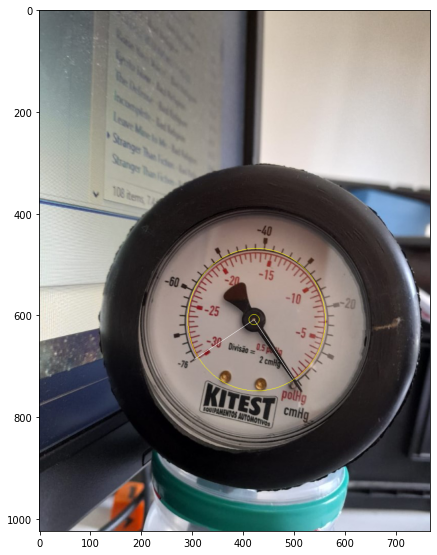

In [4]:
%matplotlib inline

import matplotlib.pyplot as plot
import numpy as np

# verificar se esta ok
image = Image.open( "vacuo.jpg" )

draw = ImageDraw.Draw( image )

bbox = [ centro[ 0 ] - raio, centro[ 1 ] - raio, centro[ 0 ] + raio, centro[ 1 ] + raio ]
draw.ellipse( bbox, fill=None, outline ="#FFFF00" )

bboxe = [   centro[ 0 ] - re + de[ 0 ], centro[ 1 ] - re + de[ 1 ], 
            centro[ 0 ] + re + de[ 2 ], centro[ 1 ] + re + de[ 3 ]]

draw.ellipse( bboxe, fill=None, outline ="#FFFF00" )

inicio = [ *centro, centro[ 0 ] + re * cos( radians( angs[ 0 ])), centro[ 1 ] + re * sin( radians( angs[ 0 ]))]
final = [ *centro, centro[ 0 ] + re * cos( radians( angs[ 1 ])), centro[ 1 ] + re * sin( radians( angs[ 1 ]))]

draw.line( inicio )
draw.line( final )

figure = plot.figure( 'imagem', figsize=( 7, 10 ))
plot.imshow(np.asarray( image ))

In [5]:
# recorta a imagem para um pouco alem dos limites da escala
corta = [ bboxe[ i ] + ( 10 if i > 1 else -10 ) for i in range( 4 )]

for i in range( 4 ):
    if corta[ i ] < 0: corta[ i ] = 0
    if i == 2:
        if corta[ i ] >= size[ 0 ]: corta[ i ] = size[ 0 ] - 1
    if i == 3:
        if corta[ i ] >= size[ 1 ]: corta[ i ] = size[ 1 ] - 1

img = Image.open( "vacuo.jpg" )
img = img.crop( corta )
img = img.convert( 'L' )

Abaixo codigo somente para verificarmos se o procedimento está funcionando (não deve ser colocado no Raspberry Pi). Aqui deveremos ter uma imagem em preto e branco apenas do vacuometro. (A imagem aparece em azul e verde neste documento porque a Matplotlib aplica esquemas de cores nas imagens pretas e brancas)

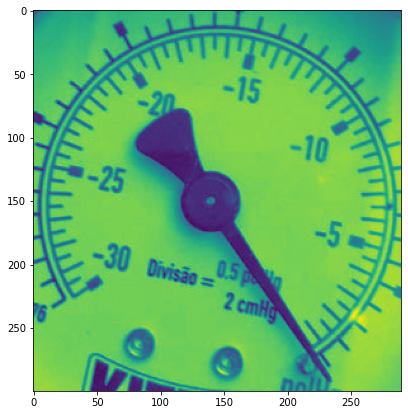

In [6]:
%matplotlib inline

import matplotlib.pyplot as plot
import numpy as np

figure = plot.figure( 'imagem', figsize=( 7, 7 ))
plot.imshow( np.asarray( img ))

Abaixo codigo somente para verificarmos se o procedimento está funcionando (não deve ser colocado no Raspberry Pi). 

Nesse caso, o que estamos testando é o algoritmo em si. O algoritmo vai iniciar perto do centro, e vai coletar pontos. Se os pontos forem escuros, significa que estamos em cima do ponteiro. Se encontramos algum ponto claro, significa que caimos fora do ponteiro, entao estamos no angulo errado.

Testamos aqui os angulos iniciais e finais para ver se estamos na posição correta. O metodo é equivalente à linha branca que traçamos, mas é preciso testar de novo, porque temos que testar o metodo exato que vai ser usado (a linha branca foi apenas um teste preliminar usando uma tecnica que nao vai ser usada no algoritmo final).

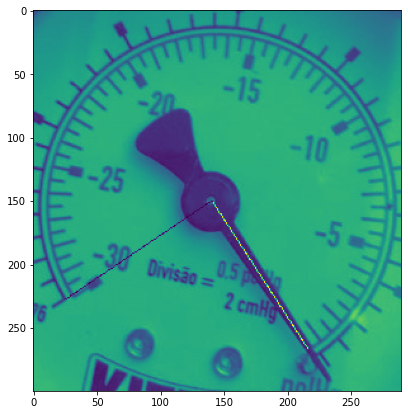

In [7]:
%matplotlib inline
# confere se as posicoes inicial e final do ponteiro estao corretas

zero = Image.open( "vacuo.jpg" )
zero = img.crop( corta )
zero = img.convert( 'L' )

centro = (( corta[ 2 ] - corta[ 0 ]) / 2, ( corta[ 3 ] - corta[ 1 ]) / 2 )

# corrige o centro
centro = ( centro[ 0 ] - 4, centro[ 1 ])

# corrige os angulos
angs = ( 57., angs[ 1 ])

ang = int( angs[ 0 ])
for px_t in range( re ):
    pos = ( int( centro[ 0 ] + float( px_t ) * cos( radians( ang ))),
            int( centro[ 1 ] + float( px_t ) * sin( radians( ang ))))
    zero.putpixel( pos, 255 ) 

ang = int( angs[ 1 ])
for px_t in range( re ):
    pos = ( int( centro[ 0 ] + float( px_t ) * cos( radians( ang ))),
            int( centro[ 1 ] + float( px_t ) * sin( radians( ang ))))
    zero.putpixel( pos, 0 ) 

import matplotlib.pyplot as plot
import numpy as np

figure = plot.figure( 'imagem', figsize=( 7, 7 ))
plot.imshow( np.asarray( zero ))

Temos que identificar o que é "escuro" e o que é "claro". Numa imagem branca e preta ocorre variação nesse parametro.

Vamos usar uma variavel chamada "limiar" e vamos colocar um valor que será o maximo valor para "escuro". (Numa imagem em tons de cinza, 0 - zero - indica o mais escuro possivel e numeros maiores - 255 se for uma imagem de 1 byte por pixel, por exemplo - indicam pontos mais claros.

O algoritmo abaixo é um teste para achar o valor ideal. Após encontrado, esse valor só vai mudar se a camera ou o vacuometro forem movimentados ou se mudarem as condições de luminosidade.

Se o codigo abaixo imprimir algum valor, quer dizer q o limiar esta baixo demais.

Se imprimir algum valor muito alto, quer dizer que ou o centro tem cores claras e precisamos medir de mais longe ( e isso indica que a distancia para ficar fora do centro precisa aumentar) ou o angulo da posicao zero do ponteiro esta errado e estamos caindo pra fora do ponteiro (o que nao deve acontecer se os testes acima estiverem ok).

Se nao imprimir nada, o limiar esta bom. O limiar deve ser o menor possivel

In [8]:
# limiar indica o tom de cinza mais claro q faz parte do ponteiro. Idealmente seria zero,
# mas na pratica é um valor maior (40 p ex). Se for alto demais, o codigo nao funciona
limiar = 40

# começa um pouco fora do centro pra evitar encontrar cores muito claras
fora_de_centro = 10

for px_t in range( fora_de_centro, re ):
    ang = int( angs[ 0 ])
    pos = ( int( centro[ 0 ] + float( px_t ) * cos( radians( ang ))),
            int( centro[ 1 ] + float( px_t ) * sin( radians( ang ))))
    px = img.getpixel( pos )

    # se imprimir algum valor, quer dizer q o limiar esta baixo demais.
    # Se imprimir algum valor muito alto, quer dizer que ou o centro tem cores claras e precisamos
    # medir de mais longe ( o fora de centro precisa aumentar) ou o angulo da posicao zero do
    # ponteiro esta errado e estamos caindo pra fora do ponteiro.
        # se nao imprimir nada, o limiar esta bom. O limiar deve ser o menor possivel
    if px > limiar: print( px )
    
print( "Se imprimiu apenas esta linha, o limiar está ok, senao, aumentar." )

Se imprimiu apenas esta linha, o limiar está ok, senao, aumentar.


<br/>

Depois de todos os ajustes, deve ser possivel fazer a medida. O código completo da função que vai fazer a medida é o codigo a seguir, com as variaveis que testamos acima repetidas.

Este é o código que vai ser usado no Raspberry Pi, e deve ser agendado para rodar em intervalos (a cada 3 minutos, talvez, via Chron).

In [65]:
from PIL import Image, ImageDraw
from math import *

def le_vacuo():
    # se mudar para 1024x768, ajustar
    size = ( 768, 1024 )

    # isolar a area da imagem onde está o vacuometro, define-se um centro e raio
    centro = ( 422, 608 )
    raio = 10

    # raio da escala - distancia da escala para o centro
    re = 140

    # achatando a escala - para caso a imagem esteja distorcida e nao esteja captando a escala
    # como um circulo perfeito
    de = [ 10, 0, 0, 0 ]   # ( +xmin, +ymin, +xmax, +ymax )

    # angulos de inicio e fim de escala, podem nao ser simetricos se na foto a escala estiver
    # rotacionada
    angs = ( 57., -214 )

    # recorta a imagem para um pouco alem dos limites da escala
    bbox = [ centro[ 0 ] - raio, centro[ 1 ] - raio, centro[ 0 ] + raio, centro[ 1 ] + raio ]

    bboxe = [   centro[ 0 ] - re + de[ 0 ], centro[ 1 ] - re + de[ 1 ], 
                centro[ 0 ] + re + de[ 2 ], centro[ 1 ] + re + de[ 3 ]]

    corta = [ bboxe[ i ] + ( 10 if i > 1 else -10 ) for i in range( 4 )]

    for i in range( 4 ):
        if corta[ i ] < 0: corta[ i ] = 0
        if i == 2:
            if corta[ i ] >= size[ 0 ]: corta[ i ] = size[ 0 ] - 1
        if i == 3:
            if corta[ i ] >= size[ 1 ]: corta[ i ] = size[ 1 ] - 1

    img = Image.open( "vacuo.jpg" )
    img = img.crop( corta )
    img = img.convert( 'L' )

    # corrige o centro 
    centro_novo = (( corta[ 2 ] - corta[ 0 ]) / 2, ( corta[ 3 ] - corta[ 1 ]) / 2 )
    centro_novo = ( centro_novo[ 0 ] - 4, centro_novo[ 1 ])
    
    # limiar indica o tom de cinza mais claro q faz parte do ponteiro. Idealmente seria zero,
    # mas na pratica é um valor maior (40 p ex). Se for alto demais, o codigo nao funciona
    limiar = 40

    # faz a medida

    # começa a tentar se deslocar do centro para a escala. Inicia no angulo inicial. Se encontrar um pixel
    # claro demais, desiste do atual e incrementa o angulo. Quando conseguir atingir a escala, conseguimos a medida.

    # passo = -1 indica q o ponteiro anda em sentido anti-horario. Se andar em horario, tem q ser passo = 1
    # Nao pode ser menor que 1 pq é preciso ser um numero inteiro, mas se for maior, reduz a precisao da
    # medida e acelera o codigo. A precisao pode ser calculada como: 
    # faixa_valores / (( |ang_final| + |ang_inicial|) / passo )
    # No caso: 740mmHg / (( 214 + 57 ) / 1 ) =  2.73mmHg (seria o dobro, 5.46mmHg, se o passo for 2, p ex)
    passo = -1

    # configura a faixa de valores do vacuometro, para calcular o resultado
    maximo = 740.
    minimo = 0.
    
    # proporcao = posicao do ponteiro (10% do curso = 0.1)
    # se for 0., o resultado cresce quando a proporcao cresce, se for 1., o
    # resultado diminui quando a proporcao cresce (o que é o caso de vacuometros)
    ordem = 1.
    
    # vai deslocando pelo angulo ate atingir a escala (ou falhar)
    for ang in range( int( angs[ 0 ]), int( angs[ 1 ]), passo ):
        errou = False

        # começa um pouco fora do centro pra evitar encontrar cores muito claras
        for px_t in range( 10, re ):
            pos = ( int( centro_novo[ 0 ] + float( px_t ) * cos( radians( ang ))),
                    int( centro_novo[ 1 ] + float( px_t ) * sin( radians( ang ))))
            px = img.getpixel( pos )
            if px > limiar: 
                print( "falha no angulo: " + str( ang ), px )
                errou = True
                break
                
        if errou == False:
            # achamos, faz o calculo 
            faixa = float( abs( angs[ 1 ] - angs[ 0 ]))
            pos_angular = abs( float( ang ) - float( angs[ 0 ]))
            
            proporcao = pos_angular / faixa
            
            faixa_valores = maximo - minimo
            valor = faixa_valores * abs( ordem - proporcao )
            
            return valor
        
    # se retornar -1, indica que ocorreu erro. Percorremos todos os angulos e nao achamos o ponteiro.
    # Nesse caso, é preciso checar tudo de novo.
    return -1.

<br/>

Vamos testar a funcao. Executada com a imagem como está, deve dar 740mmHg.

In [66]:
# testa. Na forma como a imagem está, com o vacuo em zero, deve indicar 740.

le_vacuo()

740.0

Vamos rotacionar a imagem 90o e testar de novo. Rotacionando a imagem 90o tem o mesmo efeito do ponteiro se deslocar 90o, e a medida então deve ser de um nivel de vacuo maior. O codigo abaixo é de teste e não precisa ser incluido no Raspberry Pi.

In [15]:
# gera a imagem rotacionada 90o

# se mudar para 1024x768, ajustar
size = ( 768, 1024 )

# isolar a area da imagem onde está o vacuometro, define-se um centro e raio
centro = ( 422, 608 )
raio = 10

# raio da escala - distancia da escala para o centro
re = 140

# achatando a escala - para caso a imagem esteja distorcida e nao esteja captando a escala
# como um circulo perfeito
de = [ 10, 0, 0, 0 ]   # ( +xmin, +ymin, +xmax, +ymax )

# angulos de inicio e fim de escala, podem nao ser simetricos se na foto a escala estiver
# rotacionada
angs = ( 57., -214 )

# recorta a imagem para um pouco alem dos limites da escala
bbox = [ centro[ 0 ] - raio, centro[ 1 ] - raio, centro[ 0 ] + raio, centro[ 1 ] + raio ]

bboxe = [   centro[ 0 ] - re + de[ 0 ], centro[ 1 ] - re + de[ 1 ], 
            centro[ 0 ] + re + de[ 2 ], centro[ 1 ] + re + de[ 3 ]]

corta = [ bboxe[ i ] + ( 10 if i > 1 else -10 ) for i in range( 4 )]

for i in range( 4 ):
    if corta[ i ] < 0: corta[ i ] = 0
    if i == 2:
        if corta[ i ] >= size[ 0 ]: corta[ i ] = size[ 0 ] - 1
    if i == 3:
        if corta[ i ] >= size[ 1 ]: corta[ i ] = size[ 1 ] - 1

img = Image.open( "vacuo.jpg" )
img = img.crop( corta )
img = img.convert( 'L' )
img = img.rotate( 90. );

img.save( "vacuo_90.jpg" )

<br/>

Cria versao de testes da funcao. Ela deve ser usada para verificar se o limiar esta bom, se o centro de teste foi bem informado, etc. Se for preciso fazer ajustes, ajusta-se a funcao de producao acima.


In [86]:
from PIL import Image, ImageDraw
from math import *

def le_vacuo_teste( nome_imagem, centro_novo = None ):
    # se mudar para 1024x768, ajustar
    size = ( 768, 1024 )

    # isolar a area da imagem onde está o vacuometro, define-se um centro e raio
    centro = ( 422, 608 )
    raio = 10

    # raio da escala - distancia da escala para o centro
    re = 140

    # achatando a escala - para caso a imagem esteja distorcida e nao esteja captando a escala
    # como um circulo perfeito
    de = [ 10, 0, 0, 0 ]   # ( +xmin, +ymin, +xmax, +ymax )

    # angulos de inicio e fim de escala, podem nao ser simetricos se na foto a escala estiver
    # rotacionada
    angs = ( 57., -214 )

    # recorta a imagem para um pouco alem dos limites da escala
    bbox = [ centro[ 0 ] - raio, centro[ 1 ] - raio, centro[ 0 ] + raio, centro[ 1 ] + raio ]

    bboxe = [   centro[ 0 ] - re + de[ 0 ], centro[ 1 ] - re + de[ 1 ], 
                centro[ 0 ] + re + de[ 2 ], centro[ 1 ] + re + de[ 3 ]]

    corta = [ bboxe[ i ] + ( 10 if i > 1 else -10 ) for i in range( 4 )]

    for i in range( 4 ):
        if corta[ i ] < 0: corta[ i ] = 0
        if i == 2:
            if corta[ i ] >= size[ 0 ]: corta[ i ] = size[ 0 ] - 1
        if i == 3:
            if corta[ i ] >= size[ 1 ]: corta[ i ] = size[ 1 ] - 1

    img = Image.open( nome_imagem )
    
    # a imagem deve sempre ser cortada, mas caso queiramos testar com imagens ja cortadas,
    # precisamos impedir o passo a seguir
    if ( corta[ 2 ] - corta[ 0 ]) < img.size[ 0 ]:
        img = img.crop( corta )
        img = img.convert( 'L' )

    img_debug = img.copy()
    
    # corrige o centro (deveriamos calcular o centro aqui, mas podemos querer muda-lo
    # para testes. Se o centro for informado como parametro, nao faz esse calculo)
    if centro_novo is None:
        centro_novo = (( corta[ 2 ] - corta[ 0 ]) / 2, ( corta[ 3 ] - corta[ 1 ]) / 2 )
        centro_novo = ( centro_novo[ 0 ] - 4, centro_novo[ 1 ])
    
    # limiar indica o tom de cinza mais claro q faz parte do ponteiro. Idealmente seria zero,
    # mas na pratica é um valor maior (40 p ex). Se for alto demais, o codigo nao funciona
    limiar = 41

    # faz a medida

    # começa a tentar se deslocar do centro para a escala. Inicia no angulo inicial. Se encontrar um pixel
    # claro demais, desiste do atual e incrementa o angulo. Quando conseguir atingir a escala, conseguimos a medida.

    # passo = -1 indica q o ponteiro anda em sentido anti-horario. Se andar em horario, tem q ser passo = 1
    # Nao pode ser menor que 1 pq é preciso ser um numero inteiro, mas se for maior, reduz a precisao da
    # medida e acelera o codigo. A precisao pode ser calculada como: 
    # faixa_valores / (( |ang_final| + |ang_inicial|) / passo )
    # No caso: 740mmHg / (( 214 + 57 ) / 1 ) =  2.73mmHg (seria o dobro, 5.46mmHg, se o passo for 2, p ex)
    passo = -1

    # configura a faixa de valores do vacuometro, para calcular o resultado
    maximo = 740.
    minimo = 0.
    
    # proporcao = posicao do ponteiro (10% do curso = 0.1)
    # se for 0., o resultado cresce quando a proporcao cresce, se for 1., o
    # resultado diminui quando a proporcao cresce (o que é o caso de vacuometros)
    ordem = 1.
    
    # vai deslocando pelo angulo ate atingir a escala (ou falhar)
    mult = 1
    for ang in range( int( angs[ 0 ]) * mult, int( angs[ 1 ]) * mult, passo ):
        errou = False

        # começa um pouco fora do centro pra evitar encontrar cores muito claras
        for px_t in range( 10, re ):
            fang = float( ang ) / float( mult )
            pos = ( int( centro_novo[ 0 ] + float( px_t ) * cos( radians( fang ))),
                    int( centro_novo[ 1 ] + float( px_t ) * sin( radians( fang ))))
            px = img.getpixel( pos )
            if px > limiar: 
                print( "falha no angulo: " + str( fang ), px )
                errou = True
                break
                
            img_debug.putpixel( pos, 255 )

        if errou == False:
            # achamos, faz o calculo 
            faixa = float( abs( angs[ 1 ] - angs[ 0 ]))
            fang = float( ang ) / float( mult )
            pos_angular = abs( fang - float( angs[ 0 ]))
            
            proporcao = pos_angular / faixa
            
            faixa_valores = maximo - minimo
            valor = faixa_valores * abs( ordem - proporcao )
            
            return valor
        
    # se retornar -1, indica que ocorreu erro. Percorremos todos os angulos e nao achamos o ponteiro.
    # Nesse caso, é preciso checar tudo de novo.
    
    figure = plot.figure( 'imagem', figsize=( 7, 7 ))
    plot.imshow( np.asarray( img_debug ))

    return -1.

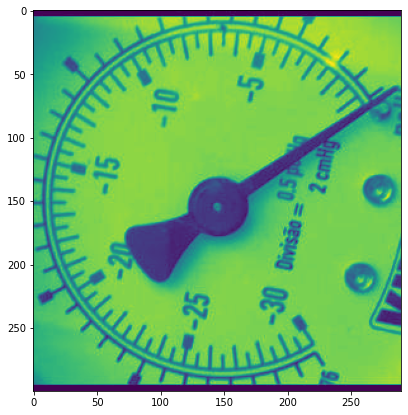

In [23]:
%matplotlib inline

# exibe a imagem rotacionada 90o para conferencia

import matplotlib.pyplot as plot
import numpy as np

teste = Image.open( "vacuo_90.jpg" )

figure = plot.figure( 'imagem', figsize=( 7, 7 ))
plot.imshow( np.asarray( teste ))


In [87]:
# teste com o ponteiro em outra posicao
%matplotlib inline

le_vacuo_teste( "vacuo_90.jpg", centro_novo = ( 145, 155 ))


falha no angulo: 57.0 56
falha no angulo: 56.0 56
falha no angulo: 55.0 75
falha no angulo: 54.0 49
falha no angulo: 53.0 49
falha no angulo: 52.0 68
falha no angulo: 51.0 68
falha no angulo: 50.0 77
falha no angulo: 49.0 61
falha no angulo: 48.0 61
falha no angulo: 47.0 85
falha no angulo: 46.0 64
falha no angulo: 45.0 64
falha no angulo: 44.0 64
falha no angulo: 43.0 79
falha no angulo: 42.0 53
falha no angulo: 41.0 53
falha no angulo: 40.0 75
falha no angulo: 39.0 62
falha no angulo: 38.0 62
falha no angulo: 37.0 62
falha no angulo: 36.0 64
falha no angulo: 35.0 64
falha no angulo: 34.0 84
falha no angulo: 33.0 84
falha no angulo: 32.0 74
falha no angulo: 31.0 55
falha no angulo: 30.0 55
falha no angulo: 29.0 55
falha no angulo: 28.0 43
falha no angulo: 27.0 71
falha no angulo: 26.0 52
falha no angulo: 25.0 52
falha no angulo: 24.0 52
falha no angulo: 23.0 78
falha no angulo: 22.0 78
falha no angulo: 21.0 67
falha no angulo: 20.0 67
falha no angulo: 19.0 67
falha no angulo: 18.0 49


494.2435424354244

<br/>

se o teste nao resultar em -1, isso indica que o algoritmo deve funcionar no caso real. No caso do teste acima, ele estaria indicando uma leitura de vacuo parcial de 494mmHg, o que parece bater com a foto do vacuometro.